<a href="https://colab.research.google.com/github/lmarches/neural-networks-and-deep-learning/blob/master/src/network-with-cross-entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is based on the code [network2.py](https://github.com/lmarches/neural-networks-and-deep-learning/blob/master/src/network2.py) by Michael Nielsen. 
It showcases the stochastic gradient descent learning algorithm for a feedforward neural network.

In [0]:
%matplotlib inline
# we specify which tensorflow version we want to use 

%tensorflow_version 2.x

# Standard library
import json
import random   
import sys

import random

# Third-party libraries
import numpy as np
import tensorflow as tf 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Get Data

Use Keras to download MNIST in one line. We split into train and test and we verify the dimensionality

In [22]:
# import mnist with keras 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66bc3a1ed0>]],
      dtype=object)

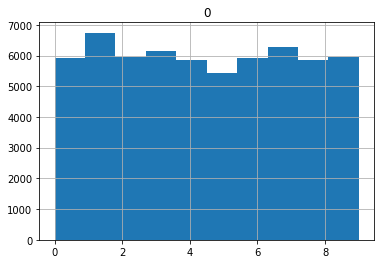

In [25]:
print ("Training data dimensionality: "+str(x_train.shape))
print ("Test data dimensionality: "+str(x_train.shape))

import pandas as pd

pd.DataFrame(data=y_train).hist()

# Data preparation

Data needs to be **normalised** between 0 and 1 and "packaged" in the right format (i.e. trainig data needs to be associated to their respective labels. 

Moreover, the labels needs to be converted into the output of the Neural networ (a 10 digit vector) 

In [0]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# we unfold  24x24 matrices corresponding to each MNIST image into 1x784 vectors 
training_inputs = [np.reshape(x.astype(np.float32)/255.0,(784,1)) for x in x_train]
# we convert a label (e.g. '9') in a 10-dim binary vector [0,0,0,0,0,0,0,0,1,0]
training_results = [vectorized_result(y) for y in y_train]
# we combine together the features and the labels 
training_data_keras = zip(training_inputs, training_results)

In [0]:
# we do the same for the test set 
test_inputs = [np.reshape(x.astype(np.float32)/255.0,(784,1)) for x in x_test]
test_results = [vectorized_result(y) for y in y_test]
test_data_keras = zip(test_inputs,y_test)

# Quadratic and cross-entropy cost functions

Define the two cost functions used in the optimization from [X-validated](https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications)

**1. Quadratic cost**

$C_{MST}(W, B, S^r, E^r) = 0.5\sum\limits_j (a^L_j - E^r_j)^2$

**2. Cross Entropy cost**

$C_{CE}(W, B, S^r, E^r) = -\sum\limits_j E^r_j \ln a^L_j + (1 - E^r_j) \ln(1-a^L_j)] $


In [0]:

class QuadraticCost(object):
       
    @staticmethod
    def fn(a, y):
        # returns the quadratic cost
        # a :  a vector containing the output of the network 
        # y :  desired output (i.e. the labels of MNIST)
        return 0.5*np.linalg.norm(a-y)**2

    # return the error delta from the output layer."""
    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
       # returns the cross-entropy cost 
       # a :  a vector containing the output of the network
       # y :  desired output (i.e. the labels of MNIST)
       
        """ Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).
        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.
        """
        return (a-y)
  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


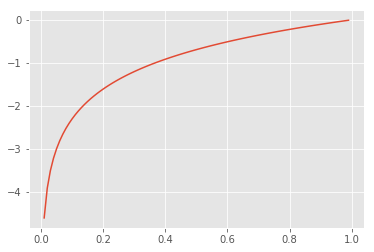

In [43]:
from matplotlib import pyplot

i = np.arange(0,1.0,0.01)
# = np.arange(-x,x,0.1)

plt.plot(i,np.log(i))

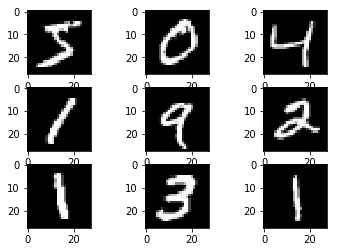

In [0]:
from matplotlib import pyplot

# visualize samples from MNIST
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()
∂

# Network architecture

This is where we define the architecture layers.  In particular: 

- The list ``sizes`` contains the number of neurons in the respective layers of the network.  
  _Example_
  
   `sizes =  [2, 3, 1]` instantiates  a three-layer network, with the first layer containing 2 neurons, the second layer 3 neurons, and the third layer 1 neuron._
- The biases and weights for the network are initialized randomly, using a Gaussian distribution with mean 0, and variance 1.  


In [0]:
#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        # set the number of layers 
        self.num_layers = len(sizes)
        # contains the number of neurons in each layer
        self.sizes = sizes
        # you need to start from somewhere.. 
        # randomly initialise weights (and biases)
        self.default_weight_initializer()
        # sets the type of cost function to use for the training
        self.cost=cost

# Initialize weights 

- **Weights Initialization** : use a Gaussian distribution with mean 0 and standard deviation 1 over the square root of the number of weights connecting to the same neuron ( neurons in the previous layer).



- Following this approach, the weighted sum of inputs at a hidden layer will not take a large value and reduces the chances of the *vanishing/exploding gradient problem*.


- **Biases Initialization** using a Gaussian distribution with mean 0 and standard deviation 1.


_Note: no biases in the first layer (input layer), since biases are only ever used in computing the outputs from later layers._

In [0]:
class Network(Network):
    
    def default_weight_initializer(self):
        # get the number of neurons in all the layers but the first one (for y in self.sizes[1:])
        # draw y random numbers to initialise the weights 
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]


        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):

        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]


# Feedforward calculation 

This is core operation of Feedforward networks: we multiply the output of previous layers with the weights of the current layer. 

Moreover we also add the bias and apply the activation function ( in this case a sigmoid)

In [0]:
# create a newtwork with three layers 
net = Network([784, 10, 10])
# initialize the weights and biases
net.default_weight_initializer()


# check  dimensionality of I/O
print ("Dimensionality of matrix with Weights connecting  -\
  input layer and hidden layer : "+str( net.weights[0].shape) ) 
print ("Dimensionality of matrix with Weights connecting hidden \
  layer and output : "+str( net.weights[1].shape) ) 

print ("Dimensionality of biases connecting hidden \
  layer and output : "+str( net.biases[0].shape) ) 
print ("Dimensionality of biases connecting hidden \
  layer and output : "+str( net.biases[1].shape) ) 

Dimensionality of matrix with Weights connecting  -  input layer and hidden layer : (10, 784)
Dimensionality of matrix with Weights connecting hidden   layer and output : (10, 10)
Dimensionality of biases connecting hidden   layer and output : (10, 1)
Dimensionality of biases connecting hidden   layer and output : (10, 1)


In [0]:
import pandas as pd 

# pd.DataFrame(data=net.weights[0].reshape(net.weights[0].shape[0]*net.weights[0].shape[1],1)).hist(bins=100)


# Misc functions

Support functions to calculate sigmoid, load a network from file, etc. 

In [0]:
#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    # opens a json file with nodes : cost, weights, biases and sizes
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z)) 


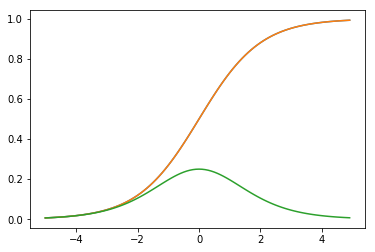

In [19]:
import numpy as np

x=5
sigm  = np.array([sigmoid(a)for a in np.arange(-x,x,0.1)],dtype=float) 

sigm_pr  = np.array([sigmoid_prime(a)for a in np.arange(-x,x,0.1)],dtype=float) 
plt.plot( np.arange(-x,x,0.1),sigm)


plt.plot( np.arange(-x,x,0.1),sigm,np.arange(-x,x,0.1), sigm_pr)


In [0]:
class Network(Network):
    def feedforward(self, a):
        # Calculate activation fucntions for all neurons in layer n-1
        for b, w in zip(self.biases, self.weights):
            # multiply weights to activation functions at layer n, add the bias
            # then sigmoid the whole thing and return activations for layer n 
            a = sigmoid(np.dot(w, a)+b)
        return a

# Backpropagation

This is one of the most important functions where we compute the gradient of the cost function with respect to the weights and the biases. 

`nabla_w` = $\delta C_x / \delta w_{jk}^l $ ( partial derivates of cost function w.r.t weights) 

`nabla_b` = $\delta C_x / \delta b_{j}^l $ ( partial derivates of cost function w.r.t. biases) 

In [0]:
class Network(Network):
        def backprop(self, x, y):
            """Return a tuple ``(nabla_b, nabla_w)`` representing the
            gradient for the cost function C_x.  ``nabla_b`` and
            ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
            to ``self.biases`` and ``self.weights``."""

            # initialize partial derivatives to zero for biases
            nabla_b = [np.zeros(b.shape) for b in self.biases]
            # initialize partial derivatives to zero for weights
            nabla_w = [np.zeros(w.shape) for w in self.weights]


            activation = x
            activations = [x] # list to store all the activations, layer by layer
            
            zs = [] # list to store all the z vectors, layer by layer

            # for each neuron's weight and bias calculate activation 
            for b, w in zip(self.biases, self.weights):
                # first multiply weights with activation and add bias 
                z = np.dot(w, activation)+b
                zs.append(z)
                activation = sigmoid(z)
                activations.append(activation)
                
            # backward pass
            delta = (self.cost).delta(zs[-1], activations[-1], y)
            nabla_b[-1] = delta
            nabla_w[-1] = np.dot(delta, activations[-2].transpose())

            # Note that the variable l in the loop below is used a little
            # differently to the notation in Chapter 2 of the book.  Here,
            # l = 1 means the last layer of neurons, l = 2 is the
            # second-last layer, and so on.  It's a renumbering of the
            # scheme in the book, used here to take advantage of the fact
            # that Python can use negative indices in lists.
            for l in xrange(2, self.num_layers):
                z = zs[-l]
                sp = sigmoid_prime(z)
                delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
                nabla_b[-l] = delta
                nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            return (nabla_b, nabla_w)

# Minibatch 
Here we use minibatch to approximate the true gradient of cost function with  a gradient computed over a minibatch of samples. 


In particular, we take a batch of samples, we calculate the derivatives of the gradient using  backprop and we update weights according to :


## $w := (1-\eta)\frac{\lambda}{n}w - \frac{\eta}{s_{mb}} \nabla C_i(w)$

where: 
- $\eta$ is the learning rate
- $\lambda$ is the regularization rate 
- $s_{mb}$ is the number of size 


In [0]:
class Network(Network):

    def update_mini_batch(self, mini_batch, eta, lmbda, n):

        """ Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  
        
        Parameters: 

        mini_batch -  is a list of tuples ``(x, y)``
        eta        -  is the learning rate
        lmbda .    -  is the regularization parameter, and
        n          - is the total size of the training data set.
        """

        # initialise weights and biases 
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # for each sample in the minibatch 
        for x, y in mini_batch:
            # compute updates to the gradient 
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)

            # calculate new gradient (partial derivatives) by adding updates
            # returned above by backprop
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # calculate new set of weights with current learning rete (eta) 
        # and regularization parameter
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    # Function to save the state of the neural net training for future 
    # sessions 
    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()


# SGD 

In [0]:

class Network(Network):
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        # set the proper size of samples, if it is not the training set 
        # get the lenght of the evaluation_data passed as parameter
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        # declare lists that will be useful later on..
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []

        # loop over the number of epochs provided as input 
        for j in xrange(epochs):
            
            # randomise the training set 
            random.shuffle(training_data)
            # spit the training set into mini batches of 
            # the given size 
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            
            # for each minibatch compute backprop 
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print "Epoch %s training complete" % j
            
            # get total cost over the training set so far 
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print "Cost on training data: {}".format(cost)
            
            # get accuracy for specific minibatch
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print "Accuracy on training data: {} / {}".format(
                    accuracy, n)
            
            # get evaluation cost and accuracy
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print "Cost on evaluation data: {}".format(cost)
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print "Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data)
            print
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy


In [0]:
# net = Network([784, 10])
# net.SGD(training_data[:1000], 30, 10, 10.0, lmbda = 1000.0,
#         evaluation_data=validation_data[:100],
#         monitor_evaluation_accuracy=True)

# Accuracy and Total Cost

In [0]:

class Network(Network):
    
    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        # if we are passing data from training set, the y is a vector of 
        # numbers ( vectorised representation),
        # pick the max and output the label as result
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        
        # if we are passing data from test or validation, dont need 
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

In [0]:
# net.SGD(training_data_keras, 30, 10, 3.0, test_data=test_data_keras)

# Train and test the Network 

In [0]:
net = Network([784, 10, 10])
net.SGD(training_data_keras, 30, 10, 0.01,
        evaluation_data=test_data_keras,
        monitor_evaluation_accuracy=True)